In [86]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

In [87]:
# Simulation parameters
TimeSplit_up = "2025-01-01"
TimeSplit_down = "2024-11-01"
starting_cash = 1000
window = 40

In [88]:
# --- Carica dati e modello ---
with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

models = {}

start_dt = pd.to_datetime(TimeSplit_down)
end_dt = pd.to_datetime(TimeSplit_up)

for tiker in stocks:
    df = pd.read_csv(
        f"csv/{tiker}_indicators.csv",
        index_col=0,
        parse_dates=[0],
        date_format="ISO8601"
    )

    bundle = joblib.load(f"models/{tiker}.joblib")
    scaler = bundle.get("scaler", None)  # legacy
    model = bundle["model"]
    features = bundle["features"]
    print(features)
    aggressive = bundle.get("aggressive", bundle.get("aggresive", None))
    threshold = bundle.get("threshold", bundle.get("threshodl", None))

    test_slice = df.loc[(df.index >= start_dt) & (df.index <= end_dt)].copy()
    # keep only the requested features (and ensure 'Close' is present for downstream code)

    entry = {
        "model": model,
        "features": features,
        "test_data": test_slice
    }

    if aggressive is not None:
        entry["aggressive"] = aggressive
        lookback_start = start_dt - pd.Timedelta(days=window)
        warm = df.loc[(df.index >= lookback_start) & (df.index < start_dt)].copy()
        entry["aggressive_warm_start_sample"] = warm.copy()
    if threshold is not None:
        entry["threshold"] = threshold

    models[tiker] = entry

['High', 'Volume', 'Return', 'MACD', 'MACD_Signal', 'MACD_Hist', 'EMA20', 'Vol_EMA20', 'RSI', 'Boll_Up', 'Boll_Down', 'Dist_low_band', 'Dist_up_band', '%K', '%D', 'R_EMA20', 'ADX', '+DI', '-DI', 'ATR', 'BB_pctB', 'ROC', 'OBV', 'CMF', 'MACD_norm', 'RSI_diff', 'DI_diff', 'SMA_slope', 'RSI_slope', 'MACD_slope', '%K_slope', '%D_slope', 'ATR_slope', 'OBV_slope', 'ADX_slope', 'RSI_overbought', 'RSI_oversold', 'Stoch_overbought', 'Stoch_oversold', 'MACD_crossover_signal', 'Vol_pct_change', 'RSI_x_Vol_Change', 'ATR_pct', 'RSI_SMA15', 'RSI_vs_SMA', 'MACD_Hist_Std20', 'SP_Return', 'SP_RSI', 'SP_Dist_SMA']


In [89]:
# Baseline: buy and hold
for tiker, data in models.items():
    print("=" * 10 + f"{tiker}" + "=" * 10)

    own_tikers = starting_cash / data["test_data"].iloc[0]["Close"]
    payout_bnh = own_tikers * data["test_data"].iloc[-1]["Close"]

==========AAPL==========


In [90]:
# Optimized Trend Chaser Strategy
for ticker, data in models.items():
    print("=" * 10 + f"{ticker}" + "=" * 10)
    
    trend_chaser = {
        "cash": starting_cash,
        "shares": 0.0,
        "prev_price": None,
        "up_streak": 0,      
        "down_streak": 0,    
        "threshold": 2,     
        "data": data["test_data"].copy()
    }

    def step(row):
        price = float(row["Close"])
        prev = trend_chaser["prev_price"]

        # Initialize on first row
        if prev is None:
            trend_chaser["prev_price"] = price
            portfolio = trend_chaser["cash"] + trend_chaser["shares"] * price
            return portfolio

        # Update streaks based on price movement
        if price > prev:
            trend_chaser["up_streak"] += 1
            trend_chaser["down_streak"] = 0
        elif price < prev:
            trend_chaser["down_streak"] += 1
            trend_chaser["up_streak"] = 0
        # If price == prev, maintain current streaks
        
        # Buy signal: Strong uptrend detected and we have cash
        if (trend_chaser["up_streak"] >= trend_chaser["threshold"] and 
            trend_chaser["cash"] > 0):
            shares_to_buy = trend_chaser["cash"] / price
            trend_chaser["shares"] += shares_to_buy
            trend_chaser["cash"] = 0.0
        
        # Sell signal: Strong downtrend detected and we have shares
        elif (trend_chaser["down_streak"] >= trend_chaser["threshold"] and 
              trend_chaser["shares"] > 0):
            cash_from_sale = trend_chaser["shares"] * price
            trend_chaser["cash"] += cash_from_sale
            trend_chaser["shares"] = 0.0

        trend_chaser["prev_price"] = price
        portfolio = trend_chaser["cash"] + trend_chaser["shares"] * price

        return portfolio
    
    # Apply strategy
    trend_chaser["data"].loc[:, "portfolio_value"] = trend_chaser["data"].apply(step, axis=1)
    
    print(len(trend_chaser["data"]))
    # Calculate final payout
    final_price = trend_chaser["data"].iloc[-1]["Close"]
    payout_tc = trend_chaser["cash"] + (trend_chaser["shares"] * final_price)

==========AAPL==========
41


In [ ]:
#Model stategy
for ticker, data in models.items():
    print("=" * 10 + f"{ticker}" + "=" * 10)

    model_state = {
        "model": data["model"],
        "cash": starting_cash,
        "shares": 0.0,
    }
    # local model handle
    model = model_state["model"]
    model_state["data"] = data["test_data"]

    if data["aggressive"] != None:
        model_state["aggressive"] = data["aggressive"]
        # build the full data (warm + test) and use its features for prediction so indexes align
        temp = pd.concat([data["aggressive_warm_start_sample"], data["test_data"]]).reset_index(drop=True)  # type: ignore
        work_data = temp.loc[:, data["features"]].copy()

        # predict on the full work_data so probability_series aligns with temp
        dmatrix = xgb.DMatrix(work_data.values, feature_names=data["features"])
        probability = model.predict(dmatrix)
        probability_series = pd.Series(probability, index=work_data.index)

        # compute rolling mean/std keeping the same index (avoid trimming -> keeps identical labels)
        roll_mean = probability_series.rolling(window=window).mean()
        roll_std = probability_series.rolling(window=window).std()
        dynamic_threshold = roll_mean + roll_std * float(data["aggressive"])
        
        # compare elementwise; fill NaNs (from the initial rolling window) with 0 actions
        actions = (probability_series > dynamic_threshold).iloc[-len(model_state["data"]):].astype(int)
    else:
        
        if data["threshold"]:
            model_state["threshold"] = data["threshold"]
        else:
            model_state["threshold"] = 0.5

        work_data = model_state["data"].loc[:, data["features"]].copy()
        dmatrix = xgb.DMatrix(work_data.values, feature_names=data["features"])
        probability = model.predict(dmatrix)
        # keep actions as an array/series matching model_state["data"]
        actions = pd.Series((probability >= model_state["threshold"]).astype(int), index=work_data.index)

    # assign model_action with aligned index/length
    print(len(model_state["data"]))
    print(len(actions))
    model_state["data"].loc[:, "model_action"] = actions.values

    def model(row):
        price = float(row["Close"])

        # STRATEGIA 

        if model_state["shares"] == 0 and row["model_action"] == 1:
            #hard buy
            model_state["shares"] += model_state["cash"] / price
            model_state["cash"] = 0.0
            model_state["streak"] = 0
        
        if model_state["shares"] != 0 and row["model_action"] == 0:
            #Hard sell
            model_state["cash"] += model_state["shares"] * price
            model_state["shares"] = 0.0
            model_state["streak"] = 0
            
        return model_state["cash"] + (model_state["shares"] * price)


    # assign results explicitly with .loc
    model_state["data"].loc[:, "model_value"] = model_state["data"].apply(model, axis=1)
    print(len(model_state["data"]))
    # final payout following the same formula used previously
    payout_mod = model_state["cash"] + (model_state["shares"] * model_state["data"].iloc[-1]["Close"])

==========AAPL==========
41
41
                 Close        High         Low        Open     Volume  \
Date                                                                    
2024-11-01  222.910004  225.350006  220.270004  220.970001   65276700   
2024-11-04  222.009995  222.789993  219.710007  220.990005   44944500   
2024-11-05  223.449997  223.949997  221.139999  221.800003   28111300   
2024-11-06  222.720001  226.070007  221.190002  222.610001   54561100   
2024-11-07  227.479996  227.880005  224.570007  224.630005   42137700   
2024-11-08  226.960007  228.660004  226.410004  227.169998   38328800   
2024-11-11  224.229996  225.699997  221.500000  225.000000   42005600   
2024-11-12  224.229996  225.589996  223.360001  224.550003   40398300   
2024-11-13  225.119995  226.649994  222.759995  224.009995   48566200   
2024-11-14  228.220001  228.869995  225.000000  225.020004   44923900   
2024-11-15  225.000000  226.919998  224.270004  226.399994   47923700   
2024-11-18  228.0200

Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1123.4130099810866 | Guadagno 12.341 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 1093.5371099080583 | Guadagno 9.354 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 1078.5565549070404 | Guadagno 7.856 %


ValueError: x and y must have same first dimension, but have shapes (41,) and (70,)

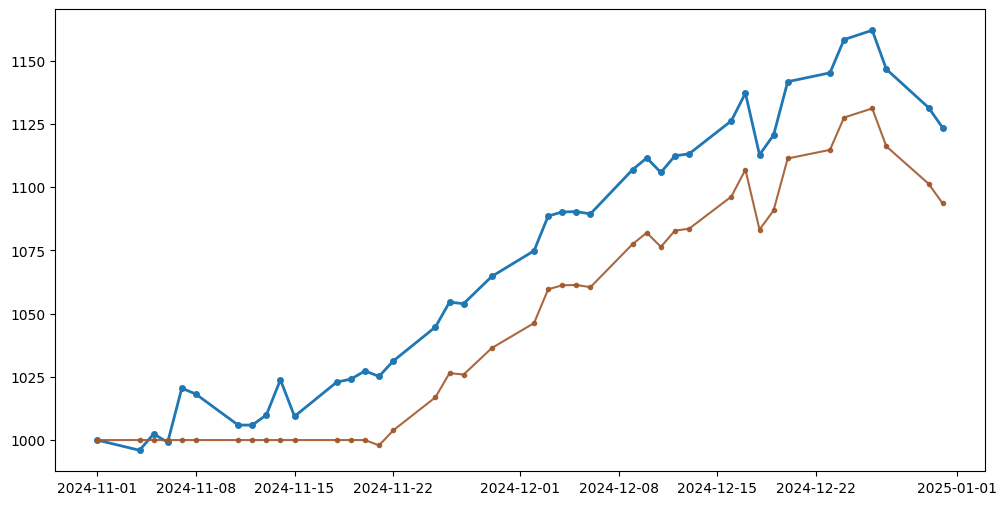

In [ ]:
print(f"Baseline 1: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_bnh} | Guadagno {((payout_bnh - starting_cash)/starting_cash) * 100:.3f} %")
print(f"Baseline 2: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_tc} | Guadagno {((payout_tc - starting_cash)/starting_cash) * 100:.3f} %")
print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_mod} | Guadagno {((payout_mod - starting_cash)/starting_cash) * 100:.3f} %")

plt.figure(figsize=(12,6))

idx = data["test_data"].index
bh_series = data["test_data"]["Close"] * own_tikers
tc_series = trend_chaser["data"]["portfolio_value"]
model_series = model_state["data"]["model_value"]

# plot lines with daily markers
plt.plot(idx, bh_series, label='Buy & hold', color='#1f77b4', linewidth=2, marker='o', markersize=4)
plt.plot(idx, tc_series, label='Trend chaser', color="#a0582c", linewidth=1.5, marker='o', markersize=3, alpha=0.9)
plt.plot(idx, model_series, label='Model', color="#2e2ca0", linewidth=1.5, marker='o', markersize=4)

# overlay buy/sell markers using model_action (show at model_value)
buys = model_state["data"]["model_action"] == 1
sells = model_state["data"]["model_action"] == 0

plt.scatter(model_state["data"].loc[buys].index, model_state["data"].loc[buys, "model_value"],
            marker="^", color="green", s=60, label="Model BUY", zorder=5)
plt.scatter(model_state["data"].loc[sells].index, model_state["data"].loc[sells, "model_value"],
            marker="v", color="red", s=60, label="Model SELL", zorder=5)

plt.title("Strategy cmp")
plt.xlabel("Date")
plt.ylabel("Money")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()